# Problema de Otimização do Transporte

## 1 - Natureza do Problema
Trata-se de um problema de maximização do lucro

In [1]:
import random
import numpy
import json
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from tabulate import tabulate

# INIT
toolbox = base.Toolbox()

# Definindo a natureza do problema. No caso um problema de maximização
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

Todas as matrizes que envolvem esse problema foram modelas como dicionarios(hash) pois facilita o acesso aos indices. Sendo assim, criou-se uma função para poder imprimir esses dicionarios na forma de tabelas para que a visualização dos dados fosse mais natural.

In [2]:
def print_dict_as_table(values_dict):
    """Função auxiliar para  imprimir imprimir os dicionarios de valores como tabela"""
    rows     = ['GMS','RNT','FRD','FAT','VKW','HYD']
    cols     = ['SAO','RIO','BSB','CNF','CWB','REC','POA']
    
    grid = []
    for a in rows:
        aux = [a]
        for b in cols:
            index = a+'-'+b
            if index in values_dict:
                aux.append(values_dict[index])
            else:
                aux.append('-')
        grid.append(aux)
    print(tabulate(grid, headers=cols))

## 2 - Variáveis e Codificação
- A codificação utilizada será um comossomo com 70 genes onde cada gene representa a rota que o caminhão está alocado.
- Como temos 25 rotas possíveis para cada caminhão precisaremos 5 bits para cada gene e logo teremos um cromossomo de tamanho 350 ($5*70$). Optou-se utilizar somente as rotas com valor ao invés de todas as possíveis, para reduzir o espaço de busca, bem como não gerar soluções inválidas
- O espaço de busca  total é de aproximadamente $2,3*10^{105}$

In [3]:
#MONTADORA-DESTINO
rotas = [
        'GMS-RIO','GMS-BSB','GMS-CNF','GMS-CWB','GMS-REC',
        'RNT-SAO','RNT-RIO','RNT-CNF','RNT-POA',
        'FRD-RIO','FRD-CWB','FRD-POA',
        'FAT-SAO','FAT-BSB','FAT-CWB','FAT-REC',
        'VKW-RIO','VKW-BSB','VKW-CWB','VKW-POA',
        'HYD-SAO','HYD-CNF','HYD-CWB','HYD-REC','HYD-POA']

# Demanda mensal dos veículos de cada MONTADORA-CENTRO_CONSUMIDOR
demandas = {
        'GMS-RIO':1701, 'GMS-BSB':1039, 'GMS-CNF':1072, 'GMS-CWB':975, 'GMS-REC':374, 
        'RNT-SAO':1903, 'RNT-RIO':684 , 'RNT-CNF':431 , 'RNT-POA':218, 
        'FRD-RIO':953 , 'FRD-CWB':547 , 'FRD-POA':304 , 
        'FAT-SAO':5246, 'FAT-BSB':1152, 'FAT-CWB':1081, 'FAT-REC':414, 
        'VKW-RIO':1689, 'VKW-BSB':1031, 'VKW-CWB':968 , 'VKW-POA':538, 
        'HYD-SAO':1360, 'HYD-CNF':308 , 'HYD-CWB':281 , 'HYD-REC':108, 'HYD-POA':156}

# Menor distância entre MONTADORA-CENTRO_CONSUMIDOR
distancias = {
        'GMS-RIO':448, 'GMS-BSB':1021, 'GMS-CNF':589 , 'GMS-CWB':445, 'GMS-REC':2709, 
        'RNT-SAO':413, 'RNT-RIO':853 , 'RNT-CNF':1001, 'RNT-POA':728, 
        'FRD-RIO':465, 'FRD-CWB':434 , 'FRD-POA':1162, 
        'FAT-SAO':554, 'FAT-BSB':746 , 'FAT-CWB':962 , 'FAT-REC':2153, 
        'VKW-RIO':465, 'VKW-BSB':1027, 'VKW-CWB':434 , 'VKW-POA':1162, 
        'HYD-SAO':157, 'HYD-CNF':650 , 'HYD-CWB':539 , 'HYD-REC':2745, 'HYD-POA':1267}

# Custo total do transporte por viagem completa realizada
custos = {
        'GMS-RIO':7948 , 'GMS-BSB':21167, 'GMS-CNF':9557 , 'GMS-CWB':6729 , 'GMS-REC':58599, 
        'RNT-SAO':5629 , 'RNT-RIO':15612, 'RNT-CNF':16679, 'RNT-POA':12365, 
        'FRD-RIO':8314 , 'FRD-CWB':6608 , 'FRD-POA':19157, 
        'FAT-SAO':7503 , 'FAT-BSB':15987, 'FAT-CWB':14991, 'FAT-REC':48046, 
        'VKW-RIO':12578, 'VKW-BSB':32363, 'VKW-CWB':9997 , 'VKW-POA':28981, 
        'HYD-SAO':1050 , 'HYD-CNF':5527 , 'HYD-CWB':4290 , 'HYD-REC':31247, 'HYD-POA':10927}

# Remuneração do transporte por viagem completa realizada
remuneracoes = {
        'GMS-RIO':10703, 'GMS-BSB':24398, 'GMS-CNF':14069, 'GMS-CWB':10626, 'GMS-REC':64746, 
        'RNT-SAO':10615, 'RNT-RIO':21923, 'RNT-CNF':25729, 'RNT-POA':18711, 
        'FRD-RIO':12606, 'FRD-CWB':11759, 'FRD-POA':31504, 
        'FAT-SAO':11407, 'FAT-BSB':15356, 'FAT-CWB':19800, 'FAT-REC':44330, 
        'VKW-RIO':11528, 'VKW-BSB':25465, 'VKW-CWB':10758, 'VKW-POA':28820, 
        'HYD-SAO':4961 , 'HYD-CNF':20537, 'HYD-CWB':17028, 'HYD-REC':86746, 'HYD-POA':40040}

Abaixo definimos a estrutura do indivíduo e da população. Essas funções serão utilizadas posteriormente pelo algoritmo.

In [4]:
# Definindo a estrutura do indivíduo
IND_SIZE = 350  # Tamanho do individuo - 10 para cada gene
GEN_SIZE = 5
GENES = IND_SIZE/GEN_SIZE

creator.create("Individual", list, fitness=creator.FitnessMax)

# funcao para gerar o gene com valores 0 ou 1 randomicamente uniforme
toolbox.register("attr_bool", random.randint, 0, 1)

# funcao para gerar o indivíduo (nome, forma de gerar, Estrutura, funcao geradora, tamanho)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=IND_SIZE)

# funcao para gerar a populacao
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def decode(individual,i_size=IND_SIZE,g_size=GEN_SIZE):
    """Recebe um individuo codificado e decodifica."""
    result = []
    for a in range(0,i_size,g_size):
        gene = ''.join(str(individual[i]) for i in range(a,a+g_size))
        index_rota = int(gene,2)
        rota = '' if index_rota > len(rotas) - 1 else rotas[index_rota]
        result.append(rota)
    return result

## 3 - Restrições
As restrições servem para definir um limite de soluções possíveis para algoritmo e, dependendo da abordagem, penalizar a função de fitness ou apenas descartas as soluções com respostas fora do intervalo.  

- **Demanda Mensal maior ou igual ao valor tabelado.**  
Criação de uma função para realização do cálculo com base no indivíduo e no valor tabelado
- **Maximo transportado por rota**
Com base no tempo que um caminhao demora, tem-se o valor máximo dia/mes que esse caminhão faz


Criou-se tabelas adicionais para facilitar o cálculo:  
- quantidade que um caminhao carrega por mes, por rota  
- quantidade de caminhoes minima por rota para atender a demanda  

In [5]:
def c_mes(distancia):
    """Carga total que um caminhao carrega no mes dada uma distancia a percorrer"""
    tempo_ida = distancia/65 + 2 #60km/h + 2hs de carga
    tempo_volta = distancia/80 + 2 #80km/h + 2hs descarga
    tempo_total = round(tempo_ida + tempo_volta)
    horas_mes = 24 * 30 #24hs * 30 dias
    viagens_mes = int(horas_mes/tempo_total)
    
    return 11 * viagens_mes #11 carros por caminhao

# Carga total mensal que um caminhao consegue carregar na rota
carga_mes = dict((rota,c_mes(distancias[rota])) for rota in rotas)

# Quantidade total de caminhoes mes para atender a demanda da rota
caminhoes_mes = dict((rota,int(demandas[rota]/carga_mes[rota])+1) for rota in rotas)

In [6]:
print('CARGA TOTAL MENSAL CAMINHAO POR ROTA:')
print_dict_as_table(carga_mes)
print('\nQUANTIDADE NECESSARIA CAMINHAO POR ROTA:')
print_dict_as_table(caminhoes_mes)

CARGA TOTAL MENSAL CAMINHAO POR ROTA:
     SAO    RIO    BSB    CNF    CWB    REC    POA
---  -----  -----  -----  -----  -----  -----  -----
GMS  -      495    242    396    495    99     -
RNT  495    275    -      242    -      -      330
FRD  -      462    -      -      495    -      220
FAT  407    -      308    -      253    121    -
VKW  -      462    231    -      495    -      220
HYD  990    -      -      352    407    88     198

QUANTIDADE NECESSARIA CAMINHAO POR ROTA:
     SAO    RIO    BSB    CNF    CWB    REC    POA
---  -----  -----  -----  -----  -----  -----  -----
GMS  -      4      5      3      2      4      -
RNT  4      3      -      2      -      -      1
FRD  -      3      -      -      2      -      2
FAT  13     -      4      -      5      4      -
VKW  -      4      5      -      2      -      3
HYD  2      -      -      1      1      2      1


Com essas tabelas já é possível verificar que a frota de 70 caminhões não consegue atender toda a demanda.

In [7]:
print('Tamanho mínimo da frota para atender a demanda: {}'.format(sum(caminhoes_mes.values())))

Tamanho mínimo da frota para atender a demanda: 82


As funções de objetivo e de restrição são criadas e utilizadas pela função de fitness. Como objetivo definimos o maior lucro e como restrição o erro médio com a quantidade ideal de caminhões por rota.

In [8]:
# diferenca com a quantidade ideal de caminhoes para atender a demanda
def restriction(arranjo):
    resultado = dict((rota,len([r for r in arranjo if rota in r] )) for rota in rotas)
    erro = 0
    for r in rotas:
        erro += abs(resultado[r]-caminhoes_mes[r])
    erro_medio = erro/sum(caminhoes_mes.values())
    return erro_medio

# funcao objetivo normalizada
def goal(arranjo):
    remuneracao = sum((remuneracoes[k]*carga_mes[k]/11) for k in arranjo if k)
    despesa = sum((custos[k]*carga_mes[k]/11) for k in arranjo if k)
    # 66794420 refere-se ao lucro maximo todos os caminhoes na rota mais lucrativa
    return (remuneracao-despesa)/66794420 

# funcao fitness
def evaluate(individual):
    arranjo = decode(individual)
    #0.5 (somado ao final) foi um fator de normalização empírico
    return goal(arranjo) - 0.35*restriction(arranjo) + 0.5, 

As funções a seguir são auxiliares para imprimir o gráfico de evolução algoritmo e as informações do melhor indivíduo.

In [9]:
def plot_log(logbook):
    """Funcao auxiliar para plotar gráfico"""
    gen = logbook.select("gen")
    min = logbook.select("min")
    avg = logbook.select("avg")
    max = logbook.select("max")
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Geração")
    ax1.set_ylabel("Fitness", color="b")
    
    line1 = ax1.plot(gen, min, "b-", label="Mínimo")
    line2 = ax1.plot(gen, avg, "g-", label="Médio")
    line3 = ax1.plot(gen, max, "y-", label="Máximo")

    lns = line3 + line2 + line1
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=4)
    
    fig.set_size_inches(15, 5, forward=True)

    plt.show()
    
def print_info(selected):
    """Funcao auxiliar para imprimir informções da solução encontrada"""   
    melhor = decode(selected)

    #conta os caminhoes por rota para comparar com o ideal
    resultado_caminhoes = dict((rota,len([r for r in melhor if rota in r] )) for rota in rotas) 
    
    #conta os caminhoes por rota para comparar com o ideal
    resultado_demanda = dict((k,v*carga_mes[k]) for k,v in resultado_caminhoes.items())

    erro = sum((demandas[r]-resultado_demanda[r]) for r in rotas if demandas[r]-resultado_demanda[r] > 0)
    divergencia = erro*100/sum(demandas.values())

    rendimento = sum((remuneracoes[k]*carga_mes[k]/11) for k in melhor if k)
    despesa = sum((custos[k]*carga_mes[k]/11) for k in melhor if k)
    lucro = rendimento-despesa

    print('\nSOLUCAO ENCONTRADA:')
    print_dict_as_table(resultado_caminhoes)
    
    #print('\nCobertura = {}%'.format(round(100-divergencia,2)))


## 8 - Código AG
Implementação de Algoritmo Genético para resolução do problema. Nesta fase, associamos as funções criadas às estruturas pré-definidas pelo framework DEAP. Também definimos os parâmetros padrões de Algoritmos Genéticos(probabilidade de cross_over e muratação e numero de gerações)

In [10]:
# registra funcao de fitness
toolbox.register("evaluate", evaluate)

# registra crossOver
toolbox.register("mate", tools.cxTwoPoint)

# registra mutacao com probabilidade default de mudar cada gene de 5%
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# registra o metodo de selecao como torneio de tamanho 2
toolbox.register("select", tools.selTournament, tournsize=2)

#semente para gerar população
random.seed(random.randint(1,200))

# cria populacao inicial
pop = toolbox.population(n=300)

# CXPB - probabilidade de crossover
# MUTPB - probabilidade de mutacao
# NGEN - numero de geracoes
CXPB, MUTPB, NGEN = 0.8, 0.03, 1000

#definindo quais stats devem ser mostrados no console
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("avg", numpy.mean)
stats.register("max", numpy.max)

Rodando o algoritmo com os parâmetros definidos:

In [11]:
#Algoritmos do livro “Evolutionary Computation 1 : Basic Algorithms and Operators”
#roda o algoritmo do capitulo 7
pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=stats, verbose=False)

Imprimindo as informações referente ao melhor indivíduo

In [12]:
#Seleciona o melhor individuo da populacao resultante
best_ind = tools.selSPEA2(pop, 1)

print('\nSOLUCAO ESPERADA:')
print_dict_as_table(caminhoes_mes)
#Imprime as informações do melhor individuo
print_info(best_ind[0])



SOLUCAO ESPERADA:
     SAO    RIO    BSB    CNF    CWB    REC    POA
---  -----  -----  -----  -----  -----  -----  -----
GMS  -      4      5      3      2      4      -
RNT  4      3      -      2      -      -      1
FRD  -      3      -      -      2      -      2
FAT  13     -      4      -      5      4      -
VKW  -      4      5      -      2      -      3
HYD  2      -      -      1      1      2      1

SOLUCAO ENCONTRADA:
     SAO    RIO    BSB    CNF    CWB    REC    POA
---  -----  -----  -----  -----  -----  -----  -----
GMS  -      4      5      3      2      3      -
RNT  4      3      -      2      -      -      1
FRD  -      3      -      -      2      -      2
FAT  13     -      1      -      5      1      -
VKW  -      2      0      -      2      -      2
HYD  2      -      -      2      1      3      2


![solucao](resultado-caminhoes.png)

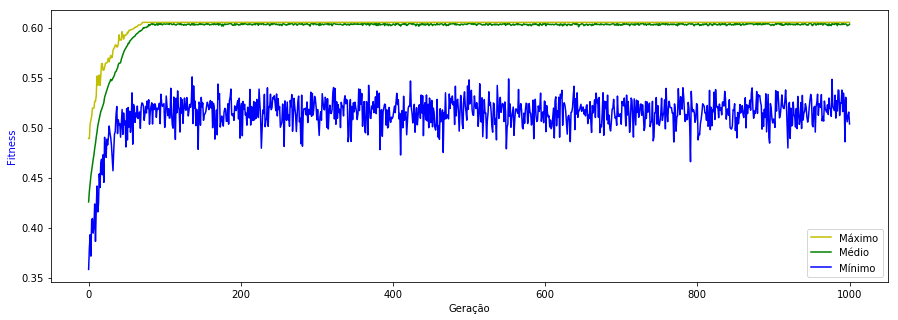

In [13]:
#Plota gráfico
plot_log(logbook)